# Univariate polynomial regression with gradient descent

In [327]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import tensorflow as tf
print(tf.__version__)
# Debugging
import sys
import logging
DEBUG_MODE = False
logging.basicConfig(level=logging.DEBUG if DEBUG_MODE else logging.INFO, stream=sys.stdout)
logging.getLogger().setLevel(logging.DEBUG if DEBUG_MODE else logging.INFO)

2.13.0


## Load data

In [328]:
# Load data
df = pd.read_csv('data.csv')
x = df['X'].to_numpy()
y = df['Y'].to_numpy()
df.head()

,X,Y
0,0.00000,6.528105
1,0.10101,4.284959
2,0.20202,5.885953
3,0.30303,8.813283
4,0.40404,8.428821


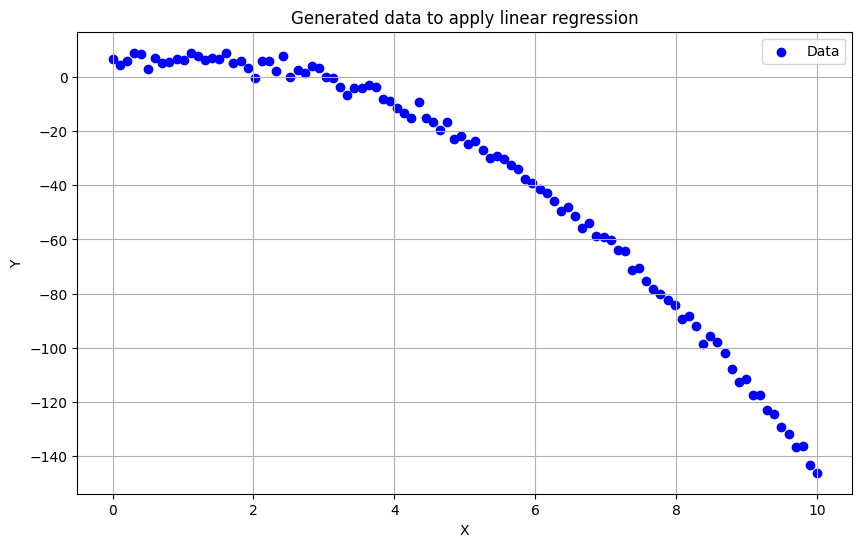

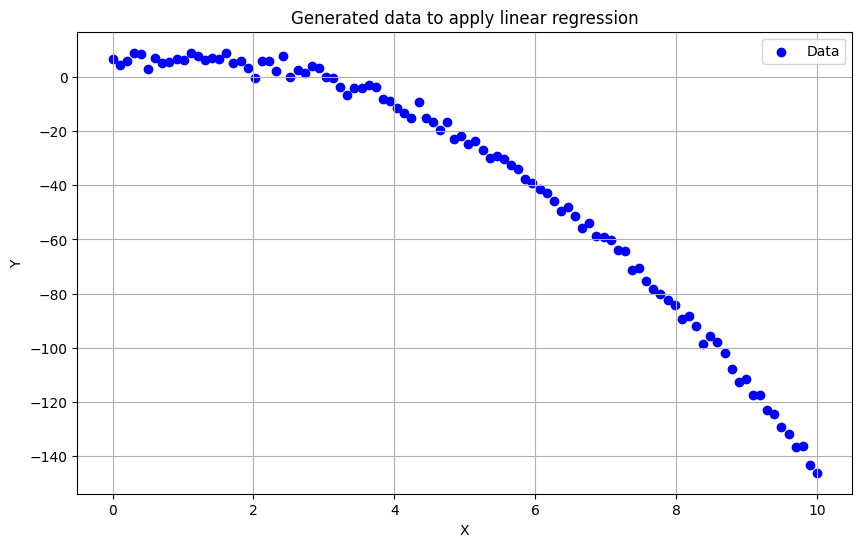

In [329]:
# Display data
def display_data(title, x, y, pred_y=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='blue', label='Data')
    if pred_y is not None:
        plt.plot(x, pred_y, color='red', label='Prediction')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)

    return plt.gcf() # To be able to draw all plots together

display_data('Generated data to apply linear regression', x, y, None)

### First using sklearn to compare the results

Apparently it uses Linear Regression to calculate Polynomial Regression, here's how:  
For polynomial y(x) = 2*x^2 + 3*x + 4, each term can be seen as a new variable, like so: y(x) = 2*w1 + 3*w2 + 4  
That allows it to use Linear Regression in a higher dimension and then do the transformation back to polynomial.  

In [330]:
def polynomialRegression(x, y):
    pf = PolynomialFeatures(degree=2, include_bias=False)
    x_transformed = pf.fit_transform(x, y)
    
    lr = LinearRegression()
    lr.fit(x_transformed, y)

    # This x here would be new data, not the same one as training, it only needs to be transformed
    # x_transformed = pf.transform(x)
    return lr.predict(x_transformed)

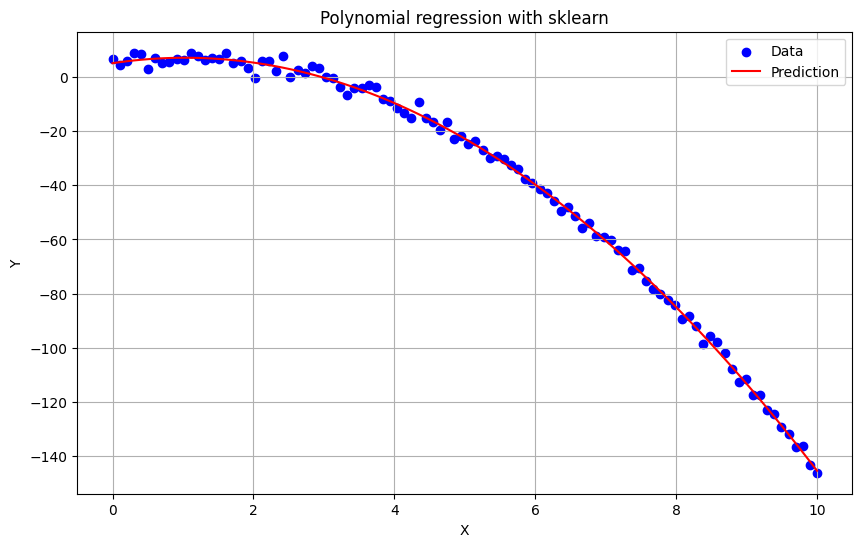

In [331]:
pred_y = polynomialRegression(x.reshape(-1, 1), y)
fig4 = display_data('Polynomial regression with sklearn', x, y, pred_y)

## Polynomial regression using tensors and auto differentiation (vectorized)

In [332]:
def expand_x_with_polynomials(x, degree):
    # expanded_x will contain all these columns x^0, x^1, x^2, ..., so they can be multiplied by the weights
    expanded_x = np.zeros((x.shape[0], degree + 1))
    # degree of the polynomial + intercept. 8*x^2 + 7*x + 5 <--- 3 weights degree 2
    for column in range(0, degree + 1):
        # newaxis expands (100,) into (100,1)
        expanded_x[:, column, np.newaxis] = (x ** column)[:]
    return expanded_x

def generate_equation_string(weights):
    equation_string = 'y(x) ='
    add_plus = ' +'
    for i, weight in enumerate(weights):
        if i == weights.shape[0] - 1:
            add_plus = ''
        equation_string += f' ({weight.numpy()[0]})*x^{i}' + add_plus
    return equation_string

class TensorflowVectorizedAutoDiffPolynomialRegression:
    def __init__(self, degree):
        # This defines how many polynomials it'll use to represent the data: x, x^2, x^3, ...
        self.degree = degree
        self.weights = self.initialize_weights()
        self.loss_history = []

    def initialize_weights(self):
        # degree of the polynomial + intercept. 8*x^2 + 7*x + 5 <--- 3 weights degree 2
        return tf.Variable(tf.zeros((self.degree + 1, 1), dtype=tf.float64))

    def update_weights(self, learning_rate, x, y, dloss_dweights):
        return self.weights - learning_rate * dloss_dweights

    def weighted_prediction(self, x, after_training=True):
        if after_training:
            # It needs to have a column per polynomial
            x = expand_x_with_polynomials(x, self.degree)
            x = tf.convert_to_tensor(x)
        return tf.matmul(x, self.weights)

    def loss_function(self, x, y, save_loss_history=False):
        # Gradient tape will calculate the derivative of the loss function with respect to weights (dloss_dweights)
        with tf.GradientTape() as g:
            g.watch(self.weights)
            # Below is the loss function calculation which will do a bunch of tensorflow operations, generating a
            # computational graph and gradient tape will automatically calculate the derivatives using that graph.
            pred_y = self.weighted_prediction(x, after_training=False)
            sum_of_distances = tf.reduce_sum((pred_y - y)**2, axis=0)[0]
            loss = (1/(2*x.shape[0]))*sum_of_distances
        # Here is where it calculates the derivatives
        dloss_dweights = g.gradient(loss, self.weights)
        if save_loss_history:
            self.loss_history.append((self.weights.numpy(), loss.numpy()))
        return loss, dloss_dweights

    def train(self, x, y, iterations=10, learning_rate=0.1, save_loss_history=False):
        self.loss_history = []
        # It needs to have a column of ones appended to it to help with the calculations related to the intercept term weight[0]
        # and also the other polynomials
        x = expand_x_with_polynomials(x, self.degree)

        # Force execution on GPU #0 if available
        if tf.config.list_physical_devices("GPU"):
            with tf.device("GPU:0"):
                # Convert to tensorflow's tensor
                x = tf.convert_to_tensor(x)
                
                self.weights = self.initialize_weights()
                current_loss, dloss_dweights = self.loss_function(x, y)
                
                for i in range(0, iterations):
                    if i % (iterations/10) == 0:
                        logging.info(f'Iteration {i}/{iterations}\tLoss: {current_loss}')
                    self.weights.assign(self.update_weights(learning_rate, x, y, dloss_dweights))
                    current_loss, dloss_dweights = self.loss_function(x, y, save_loss_history=save_loss_history)
                
                logging.info(f'Final {i+1}/{iterations}\tLoss: {current_loss}\tWeights: {self.weights}')
                equation_string = generate_equation_string(self.weights)
                logging.info(f'Equation: {equation_string}')
    

In [333]:
# Input x is a 1D array and here is converted into a 2D vector of shape (n_examples, 1)
new_x = np.expand_dims(x, axis=0).T
new_y = np.expand_dims(y, axis=0).T

In [334]:
%%time
iterations = 10000
pr = TensorflowVectorizedAutoDiffPolynomialRegression(degree=2)
pr.train(new_x, new_y, iterations, learning_rate=0.0001)
pred_y = pr.weighted_prediction(new_x)

INFO:root:Iteration 0/10000	Loss: 1825.6612216362312
INFO:root:Iteration 1000/10000	Loss: 27.026887944766887
INFO:root:Iteration 2000/10000	Loss: 17.52919956993166
INFO:root:Iteration 3000/10000	Loss: 11.656546011246073
INFO:root:Iteration 4000/10000	Loss: 8.024092787712911
INFO:root:Iteration 5000/10000	Loss: 5.7760638715625126
INFO:root:Iteration 6000/10000	Loss: 4.38362113459434
INFO:root:Iteration 7000/10000	Loss: 3.519961581976562
INFO:root:Iteration 8000/10000	Loss: 2.983132223076736
INFO:root:Iteration 9000/10000	Loss: 2.648332615522912
INFO:root:Final 10000/10000	Loss: 2.4384396626455183	Weights: <tf.Variable 'Variable:0' shape=(3, 1) dtype=float64, numpy=
array([[ 2.28541631],
       [ 4.53143547],
       [-1.9274278 ]])>
INFO:root:Equation: y(x) = (2.285416309679783)*x^0 + (4.531435469567849)*x^1 + (-1.927427797275702)*x^2
CPU times: user 27.4 s, sys: 172 ms, total: 27.5 s
Wall time: 27.6 s


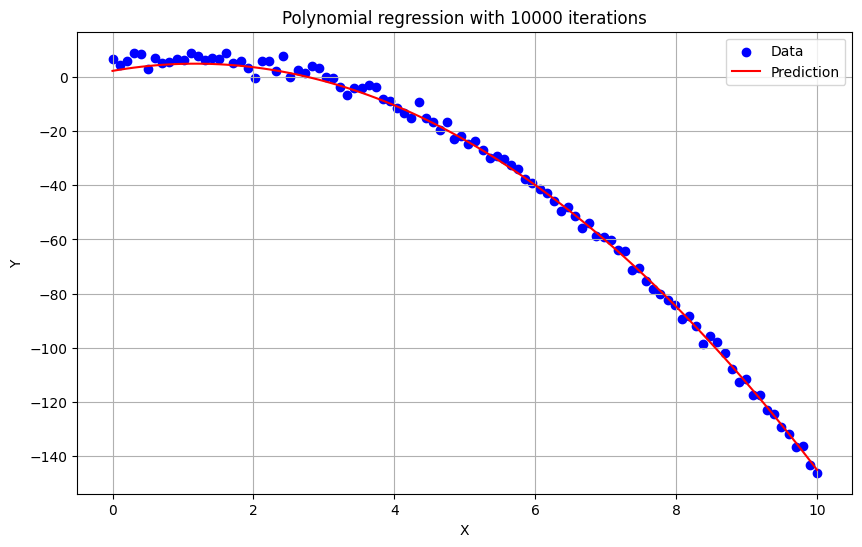

In [335]:
fig4 = display_data(f'Polynomial regression with {iterations} iterations', x, y, pred_y)

In [336]:
%%capture
def createPolynomialRegressionFigure(x, y, iterations, degree, save_loss_history = False):
    pr = TensorflowVectorizedAutoDiffPolynomialRegression(degree)
    pr.train(new_x, new_y, iterations=iterations, learning_rate=0.0001, save_loss_history=save_loss_history)
    pred_y = pr.weighted_prediction(new_x)
    return display_data(f'Polynomial regression with {iterations} iterations', x, y, pred_y)
fig1 = createPolynomialRegressionFigure(new_x, new_y, iterations=1, degree=2)
fig2 = createPolynomialRegressionFigure(new_x, new_y, iterations=10, degree=2)
fig3 = createPolynomialRegressionFigure(new_x, new_y, iterations=100, degree=2)

INFO:root:Iteration 0/1	Loss: 1825.6612216362312
INFO:root:Final 1/1	Loss: 1165.9486713671547	Weights: <tf.Variable 'Variable:0' shape=(3, 1) dtype=float64, numpy=
array([[-0.00388838],
       [-0.03224496],
       [-0.26926016]])>
INFO:root:Equation: y(x) = (-0.0038883750972298035)*x^0 + (-0.03224495631666444)*x^1 + (-0.26926016472307784)*x^2
INFO:root:Iteration 0/10	Loss: 1825.6612216362312
INFO:root:Iteration 1/10	Loss: 1165.9486713671547
INFO:root:Iteration 2/10	Loss: 750.279355770911
INFO:root:Iteration 3/10	Loss: 488.37328440893833
INFO:root:Iteration 4/10	Loss: 323.34814326066373
INFO:root:Iteration 5/10	Loss: 219.36434447641685
INFO:root:Iteration 6/10	Loss: 153.84059755517418
INFO:root:Iteration 7/10	Loss: 112.54920872845969
INFO:root:Iteration 8/10	Loss: 86.52579795014012
INFO:root:Iteration 9/10	Loss: 70.12221795700658
INFO:root:Final 10/10	Loss: 59.779765598569256	Weights: <tf.Variable 'Variable:0' shape=(3, 1) dtype=float64, numpy=
array([[-0.01379806],
       [-0.13374523

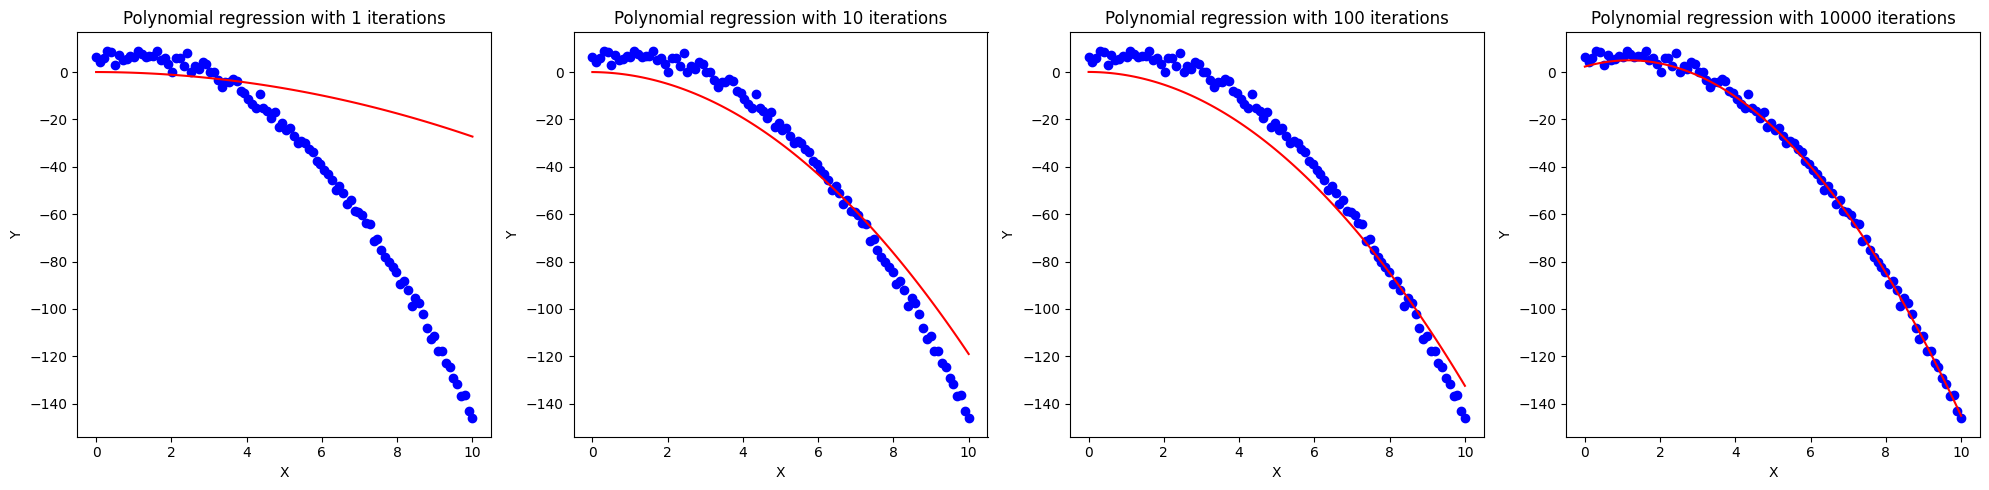

In [337]:
stored_figs = [fig1, fig2, fig3, fig4]

def display_all_together(figures):
    n = len(figures)
    fig, axs = plt.subplots(1, n, figsize=(5*n, 5))
    
    for i, ax in enumerate(axs):
        # Plot the lines
        for line in figures[i].axes[0].lines:
            ax.plot(line.get_xdata(), line.get_ydata(), color=line.get_color())
        
        # Plot the scatter points
        for collection in figures[i].axes[0].collections:
            scatter_data = collection.get_offsets()
            ax.scatter(scatter_data[:, 0], scatter_data[:, 1], color=collection.get_facecolor())
        
        ax.set_title(figures[i].axes[0].get_title())
        ax.set_xlabel(figures[i].axes[0].get_xlabel())
        ax.set_ylabel(figures[i].axes[0].get_ylabel())
    
    plt.tight_layout()
    plt.show()

display_all_together(stored_figs)

### Other interesting plots

INFO:root:Iteration 0/10000	Loss: 1825.6612216362312
INFO:root:Iteration 1000/10000	Loss: 1688.6203673396212
INFO:root:Iteration 2000/10000	Loss: 1576.4219275637206
INFO:root:Iteration 3000/10000	Loss: 1484.562533131605
INFO:root:Iteration 4000/10000	Loss: 1409.3551740784062
INFO:root:Iteration 5000/10000	Loss: 1347.7812121475238
INFO:root:Iteration 6000/10000	Loss: 1297.3692200819107
INFO:root:Iteration 7000/10000	Loss: 1256.095784617806
INFO:root:Iteration 8000/10000	Loss: 1222.3042916573124
INFO:root:Iteration 9000/10000	Loss: 1194.6384338565465
INFO:root:Final 10000/10000	Loss: 1171.98777178763	Weights: <tf.Variable 'Variable:0' shape=(1, 1) dtype=float64, numpy=array([[-24.57993365]])>
INFO:root:Equation: y(x) = (-24.579933650391048)*x^0


''

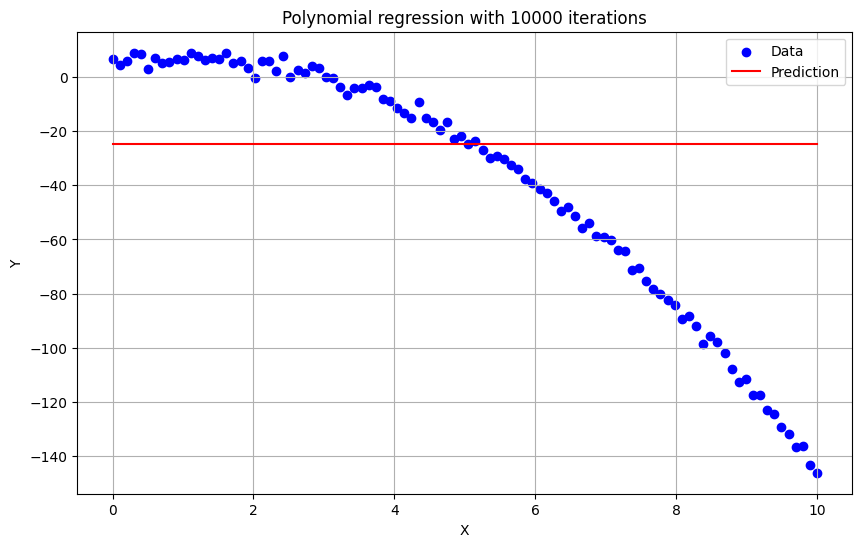

In [338]:
# Fit a degree 0 polynomial into the data
createPolynomialRegressionFigure(new_x, new_y, iterations=10000, degree=0)
;

INFO:root:Iteration 0/10000	Loss: 1825.6612216362312
INFO:root:Iteration 1000/10000	Loss: 280.01435374460345
INFO:root:Iteration 2000/10000	Loss: 270.0400577468441
INFO:root:Iteration 3000/10000	Loss: 262.07731562497736
INFO:root:Iteration 4000/10000	Loss: 254.50179637313516
INFO:root:Iteration 5000/10000	Loss: 247.29314970301058
INFO:root:Iteration 6000/10000	Loss: 240.43360686016533
INFO:root:Iteration 7000/10000	Loss: 233.90626127394947
INFO:root:Iteration 8000/10000	Loss: 227.6950251350362
INFO:root:Iteration 9000/10000	Loss: 221.78458974230765
INFO:root:Final 10000/10000	Loss: 216.1603877718233	Weights: <tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[  6.90413277],
       [-10.62242011]])>
INFO:root:Equation: y(x) = (6.904132766239545)*x^0 + (-10.622420106236627)*x^1


''

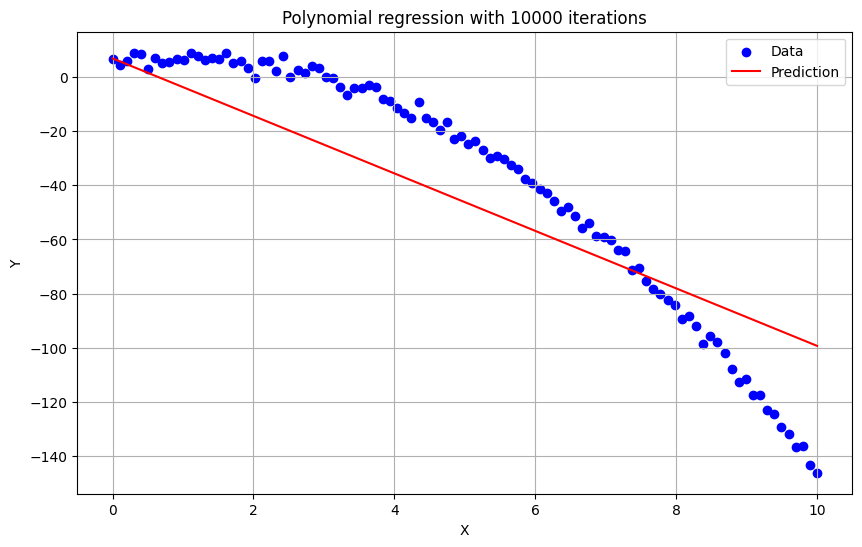

In [339]:
# Fit a degree 1 into the data and show loss
iterations = 10000
pr = TensorflowVectorizedAutoDiffPolynomialRegression(degree=1)
pr.train(new_x, new_y, iterations=iterations, learning_rate=0.0001, save_loss_history=True)
pred_y = pr.weighted_prediction(new_x)
display_data(f'Polynomial regression with {iterations} iterations', x, y, pred_y)
;

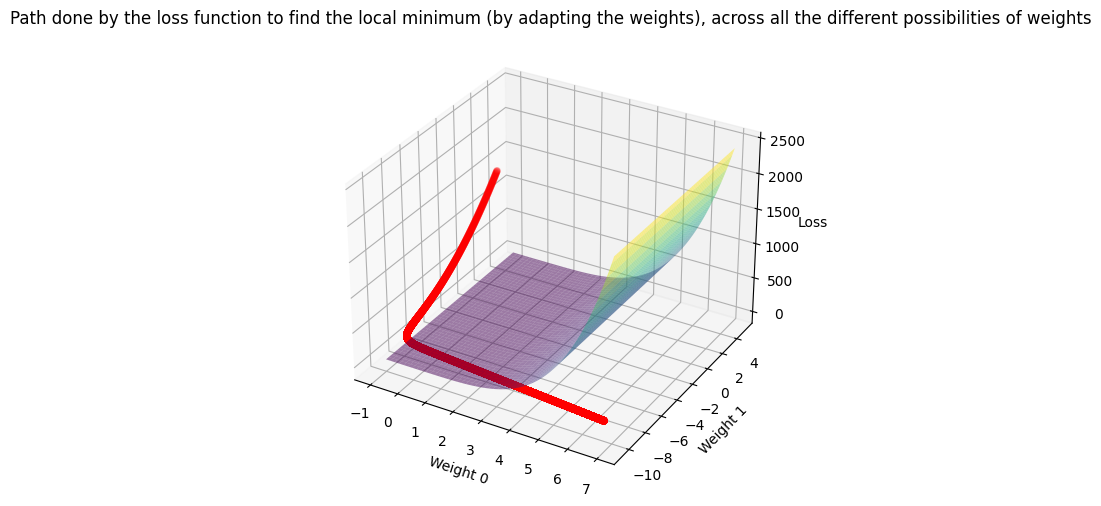

In [351]:
def plot_loss_function():
    # Extracting x, y, and z data
    x_data = [point[0][0][0] for point in pr.loss_history]
    y_data = [point[0][1][0] for point in pr.loss_history]
    z_data = [point[1] for point in pr.loss_history]
    
    # Plotting the data
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_data, y_data, z_data, c='r', marker='o')

    x_vals = np.linspace(-1, 7, 100)
    y_vals = np.linspace(-10, 5, 100)
    x_mesh, y_mesh = np.meshgrid(x_vals, y_vals)
    z_parabolic = x_mesh**4
    ax.plot_surface(x_mesh, y_mesh, z_parabolic, alpha=0.5, cmap='viridis', edgecolor='none')
    
    ax.set_xlabel('Weight 0')
    ax.set_ylabel('Weight 1')
    ax.set_zlabel('Loss')
    plt.title('Path done by the loss function to find the local minimum (by adapting the weights), across all the different possibilities of weights')
    
    plt.show()

loss_data = pr.compute_loss(x, y, range_weights)
plot_loss_function(loss_data)

INFO:root:Iteration 0/10000	Loss: 1825.6612216362312
INFO:root:Iteration 1000/10000	Loss: nan
INFO:root:Iteration 2000/10000	Loss: nan
INFO:root:Iteration 3000/10000	Loss: nan
INFO:root:Iteration 4000/10000	Loss: nan
INFO:root:Iteration 5000/10000	Loss: nan
INFO:root:Iteration 6000/10000	Loss: nan
INFO:root:Iteration 7000/10000	Loss: nan
INFO:root:Iteration 8000/10000	Loss: nan
INFO:root:Iteration 9000/10000	Loss: nan
INFO:root:Final 10000/10000	Loss: nan	Weights: <tf.Variable 'Variable:0' shape=(4, 1) dtype=float64, numpy=
array([[nan],
       [nan],
       [nan],
       [nan]])>
INFO:root:Equation: y(x) = (nan)*x^0 + (nan)*x^1 + (nan)*x^2 + (nan)*x^3


''

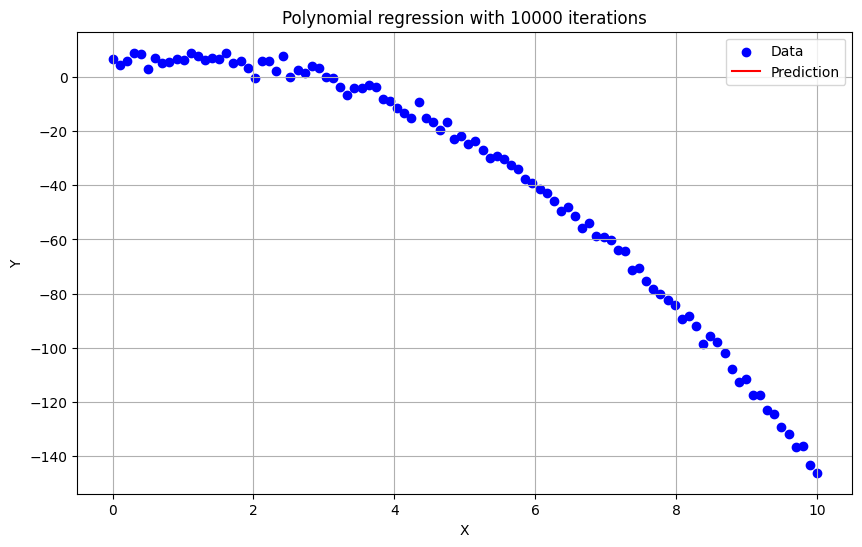

In [341]:
# Fit a degree 30 into the data
createPolynomialRegressionFigure(new_x, new_y, iterations=10000, degree=3)
;